In [151]:
RKP = "DL031"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

sns.set_theme(style="darkgrid")

In [152]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv(city="./data/rkpuram.csv"):
    met = pd.read_csv(city,delimiter=';',skiprows=24)
    aqi = pd.read_csv('./data/station_hour.csv')
    print(aqi.columns)
    met.rename(columns={'# Date': 'Date',}, inplace=True)
    met.rename(columns={'UT time': 'Time',}, inplace=True)
    aqi['Time'] = aqi['Datetime'].str[-8:-3]
    aqi['Date'] = aqi['Datetime'].str[0:10]
    stations = ["DL"+str(x).zfill(3) for x in range(1,39)]
    split_aqi = {}
    for i in range(len(stations)):
        split_aqi[stations[i]] = (aqi[aqi['StationId'] == stations[i]])
    return met,aqi,split_aqi
met,aqi,split_aqi = loadcsv()

c:\users\confusement\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [153]:
# Pre - processing and loading data
class dataset:
    def __init__(self,met,aqi,split_aqi):
            self.metro_data = met
            self.aqi_data = aqi
            self.split_aqi = split_aqi
    def mergedData(self,station,rlist=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI'],roll=48,shift=72):
        df_aqi = self.getdf(station)
        df = pd.merge(df_aqi, self.metro_data, how='inner', on=['Date', 'Time'])
        print("Merged Dataset Size",len(df))
        
        #Pre Processing merged Data
        df['Year'] = df['Date'].str[0:4]
        df['Month'] = df['Date'].str[5:7].astype(np.float64)
        df['Day'] = df['Date'].str[8:10].astype(np.float64)
        df['Hour'] = df['Time'].str[0:2]
        
        # TRIG TRANSFORMATIONS
        df['windX'] = np.cos(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['windY'] = np.sin(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['hourX'] = np.cos((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['hourY'] = np.sin((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['MonthX'] = np.cos((df['Month'].astype(np.float64)-1)*np.pi/12)
        df['MonthY'] = np.sin((df['Month'].astype(np.float64)-1)*np.pi/12)
        
        import datetime
        df['Date'] = pd.to_datetime(df['Date'])
        df['isWeekend'] =  (df['Date'].dt.dayofweek>=5).astype(int)
        
        df.interpolate(method='linear', limit=5,inplace=True)
        
        # Drop Additional columns
        df.drop('Benzene', axis=1, inplace=True)
        df.drop('Toluene',axis=1, inplace=True)
        df.drop('Xylene', axis=1,inplace=True)
        df.drop('AQI_Bucket',axis=1,inplace=True)
        df.drop('Datetime',axis=1,inplace=True)
        df.drop('StationId',axis=1,inplace=True)
        df.drop('Short-wave irradiation',axis=1,inplace=True)
        df.drop('Date',axis=1,inplace=True)
        df.drop('Time',axis=1,inplace=True)
        
        # Rolling and shifting 
        print("Size before roll",len(df))
        for i in rlist:
            df[i+'_lag1'] = df[i].shift(24)
            df[i+'_lag2'] = df[i].shift(48)
            df[i+'_lag3'] = df[i].shift(72)
        for i in rlist:
            df[i+"_pred1"] = df[i].shift(-24)
            df[i+"_pred2"] = df[i].shift(-48)
            df[i+"_pred3"] = df[i].shift(-72)
        newlist = rlist + ['Temperature','Relative Humidity','windX','windY']
        for i in newlist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(j)
                df[i+"_t+"+str(j)] = df[i].shift(-j-shift)
        futurelist = ['Year','MonthX','MonthY','hourX','hourY','isWeekend']
        for i in futurelist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(-(shift+23-j))
        df.dropna(inplace=True)
        print("Size after roll",len(df))
        
        return df.copy()
    def getdf(self,station):
        return self.split_aqi[station]
    def plot(self,station):
        df = self.getdf(station)
    def stats(self):
        pass

In [155]:
# CNN Model Testing as well
def getSplitFeatures(df,TIME_SERIES_LENGTH = 24):
    features = []
    rlist=['PM2.5','PM10','NO','NO2','CO','AQI']
    for it in rlist:
        print(it,np.mean(df[it]),np.std(df[it]))
    newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
    for j in range(24):
        for i in newlist:
            features.append(i+'_t-'+str(j))
    predVector = []
    for j in range(24):
        predVector.append('PM2.5_t+'+str(j))
    X = df[features]
    y = df[predVector]
    X = np.array(X).reshape(X.shape[0],TIME_SERIES_LENGTH,len(newlist))
    scaler = StandardScaler()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
    Xtrain = scaler.fit_transform(Xtrain.reshape(Xtrain.shape[0],TIME_SERIES_LENGTH*len(newlist)))
    Xtrain = Xtrain.reshape(Xtrain.shape[0],TIME_SERIES_LENGTH,len(newlist))
    Xtest = scaler.transform(Xtest.reshape(Xtest.shape[0],TIME_SERIES_LENGTH*len(newlist)))
    Xtest = Xtest.reshape(Xtest.shape[0],TIME_SERIES_LENGTH,len(newlist))
    return Xtrain,ytrain,Xtest,ytest

In [159]:
def trainModel1(Xtrain,ytrain,Xtest,ytest,TIME_SERIES_LENGTH=24):
    model = Sequential()
    # model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(Conv1D(128, 3,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # model.add(LSTM(200,activation='relu',input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    # model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(TIME_SERIES_LENGTH,len(newlist))))
    # model.add(Dense(200, activation='relu'))
    
    model.add(Dense(24, activation='relu'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(Xtrain, ytrain, epochs=200, batch_size=256,  verbose=1, validation_split=0.2)
    return model,history

In [160]:
def predictStats(model,Xtrain,ytrain,Xtest,ytest):
    testPred = model.predict(Xtest)
    trainPred = model.predict(Xtrain)
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))
    print(mean_absolute_error(testPred, ytest))
    print(mean_absolute_error(trainPred, ytrain))
def plothistory(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('model loss')
    plt.ylabel('RMSE loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

Merged Dataset Size 44035
Size before roll 44035
Size after roll 11596
PM2.5 102.14626081956295 82.29759489131531
PM10 216.3002180308481 141.8134423731434
NO 43.17497931401046 81.89773244893385
NO2 58.702180613527936 41.01196908713821
CO 1.5506782982223413 2.153596798375222
AQI 224.7247650051742 111.16981620228673
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_117 (Conv1D)          (None, 22, 128)           6272      
_________________________________________________________________
batch_normalization_99 (Batc (None, 22, 128)           512       
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 17, 128)           98432     
_________________________________________________________________
batch_normalization_100 (Bat (None, 17, 128)           512       
_________________________________________________________________
c

25/25 [==============================] - 5s 194ms/step - loss: 975.2178 - mse: 975.2178 - mae: 21.5572 - val_loss: 1098.7650 - val_mse: 1098.7650 - val_mae: 22.9867
Epoch 37/200
25/25 [==============================] - 4s 172ms/step - loss: 1000.9492 - mse: 1000.9492 - mae: 22.0924 - val_loss: 1055.7306 - val_mse: 1055.7306 - val_mae: 23.0541
Epoch 38/200
25/25 [==============================] - 4s 174ms/step - loss: 927.8609 - mse: 927.8609 - mae: 21.1456 - val_loss: 962.1454 - val_mse: 962.1454 - val_mae: 21.4949
Epoch 39/200
25/25 [==============================] - 4s 168ms/step - loss: 897.3201 - mse: 897.3201 - mae: 20.6924 - val_loss: 964.2725 - val_mse: 964.2725 - val_mae: 21.9074
Epoch 40/200
25/25 [==============================] - 4s 144ms/step - loss: 865.9007 - mse: 865.9007 - mae: 20.3176 - val_loss: 948.8651 - val_mse: 948.8651 - val_mae: 21.4235
Epoch 41/200
25/25 [==============================] - 4s 147ms/step - loss: 856.9461 - mse: 856.9461 - mae: 20.3261 - val_loss:

25/25 [==============================] - 4s 162ms/step - loss: 408.0902 - mse: 408.0902 - mae: 13.9309 - val_loss: 447.2578 - val_mse: 447.2578 - val_mae: 14.5231
Epoch 83/200
25/25 [==============================] - 4s 156ms/step - loss: 400.6190 - mse: 400.6190 - mae: 13.8358 - val_loss: 480.9281 - val_mse: 480.9281 - val_mae: 14.9707
Epoch 84/200
25/25 [==============================] - 4s 157ms/step - loss: 373.6512 - mse: 373.6512 - mae: 13.3700 - val_loss: 443.9196 - val_mse: 443.9196 - val_mae: 14.3092
Epoch 85/200
25/25 [==============================] - 3s 138ms/step - loss: 368.2013 - mse: 368.2013 - mae: 13.2112 - val_loss: 435.8628 - val_mse: 435.8628 - val_mae: 14.2411
Epoch 86/200
25/25 [==============================] - 5s 195ms/step - loss: 363.4749 - mse: 363.4749 - mae: 13.1356 - val_loss: 420.0450 - val_mse: 420.0450 - val_mae: 13.9581
Epoch 87/200
25/25 [==============================] - 4s 160ms/step - loss: 367.3010 - mse: 367.3010 - mae: 13.2342 - val_loss: 420.3

25/25 [==============================] - 4s 144ms/step - loss: 242.6524 - mse: 242.6524 - mae: 10.9940 - val_loss: 346.7868 - val_mse: 346.7868 - val_mae: 12.5905
Epoch 129/200
25/25 [==============================] - 4s 152ms/step - loss: 251.0874 - mse: 251.0874 - mae: 11.1600 - val_loss: 353.6856 - val_mse: 353.6856 - val_mae: 12.8329
Epoch 130/200
25/25 [==============================] - 4s 174ms/step - loss: 249.5507 - mse: 249.5507 - mae: 11.1630 - val_loss: 334.8743 - val_mse: 334.8743 - val_mae: 12.4928
Epoch 131/200
25/25 [==============================] - 4s 153ms/step - loss: 238.7658 - mse: 238.7658 - mae: 10.9107 - val_loss: 339.5143 - val_mse: 339.5143 - val_mae: 12.5742
Epoch 132/200
25/25 [==============================] - 4s 155ms/step - loss: 250.2217 - mse: 250.2217 - mae: 11.2043 - val_loss: 337.3073 - val_mse: 337.3073 - val_mae: 12.4484
Epoch 133/200
25/25 [==============================] - 4s 168ms/step - loss: 250.6822 - mse: 250.6822 - mae: 11.2585 - val_loss: 

25/25 [==============================] - 4s 160ms/step - loss: 178.8717 - mse: 178.8717 - mae: 9.7021 - val_loss: 299.3088 - val_mse: 299.3088 - val_mae: 11.6488
Epoch 175/200
25/25 [==============================] - 4s 162ms/step - loss: 173.2027 - mse: 173.2027 - mae: 9.5133 - val_loss: 294.8911 - val_mse: 294.8911 - val_mae: 11.5861
Epoch 176/200
25/25 [==============================] - 4s 155ms/step - loss: 187.7842 - mse: 187.7842 - mae: 9.9842 - val_loss: 308.9007 - val_mse: 308.9007 - val_mae: 11.8139
Epoch 177/200
25/25 [==============================] - 3s 138ms/step - loss: 189.9111 - mse: 189.9111 - mae: 10.0011 - val_loss: 308.9485 - val_mse: 308.9485 - val_mae: 11.8246
Epoch 178/200
25/25 [==============================] - 4s 160ms/step - loss: 190.0991 - mse: 190.0991 - mae: 10.0090 - val_loss: 318.9729 - val_mse: 318.9729 - val_mae: 12.4299
Epoch 179/200
25/25 [==============================] - 4s 155ms/step - loss: 190.7363 - mse: 190.7363 - mae: 10.1009 - val_loss: 303

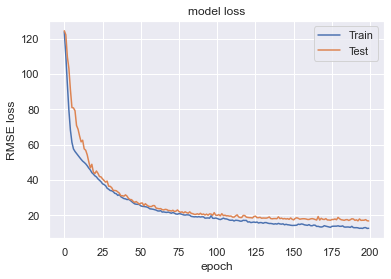

In [161]:
dat = dataset(met,aqi,split_aqi)
df = dat.mergedData('DL031',roll=48,shift=72)
Xtrain,ytrain,Xtest,ytest = getSplitFeatures(df,TIME_SERIES_LENGTH = 24)
model,history = trainModel1(Xtrain,ytrain,Xtest,ytest,TIME_SERIES_LENGTH=24)
model.save('3daypm1_366')
predictStats(model,Xtrain,ytrain,Xtest,ytest)
plothistory(history)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

# features.append("CO_lag1")
# features.append("CO_lag2")

# features.append("O3_lag1")
# features.append("O3_lag2")

# features.append("NH3_lag1")
# features.append("NH3_lag2")

# features = []
# rlist=['PM2.5','PM10','NO','NO2','CO']
# newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
# for i in newlist:
#     for j in range(24):
#         features.append(i+'_t-'+str(j))
        
X = df[features]
y = df['PM2.5_pred3']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = LinearRegression().fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
        
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = MLPRegressor(random_state=1, max_iter=100).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

In [126]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))

X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
print(Xtrain.shape,ytrain.shape)
# scaler.fit(Xtrain)

reg = SVR(C=3.0, epsilon=0.2).fit(Xtrain, ytrain)

testPred = reg.predict(Xtest)
trainPred = reg.predict(Xtrain)
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(Xtest, ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

(7769, 360) (7769,)
0.3379685723175532
65.78093011534429
67.0801815314519
43.41983467544137
43.25189223855267


In [ ]:
import tensorflow as tf  
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df[predVector]
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
print(Xtrain.shape)
model = Sequential()
model.add(Dense(200, input_dim=360, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(24, activation='linear'))
model.summary()
#Fit
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(scaler.transform(Xtrain), ytrain, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)
#Print Accuracy
testPred = model.predict(scaler.transform(Xtest))
trainPred = model.predict(scaler.transform(Xtrain))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))
print(mean_absolute_error(testPred, ytest))
print(mean_absolute_error(trainPred, ytrain))

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('RMSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()